<b><font size=5><center>Исследование и выявление зависимости поведения пользователей игры "Космические братья" от каналов привлечения.<br>Финальный проект.</center></font></b>

Ссылка на дашборд: https://public.tableau.com/views/final_prj_games/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

Ссылка на презентацию: https://disk.yandex.ru/i/Dt7VaFmQMvhdVg

### Цель исследования

Необходимо понять, как канал привлечения влияет на поведение игроков. Данное исследование - своего рода тестовая закупка. Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

### Описание датасетов

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. 

Датасет *ad_cost.csv*:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение


### Описание проекта

В ходе исследования мы изучили данные и привели к нужному виду, проверили на аномалии и очистили данные, построили и проанализировали воронку событий. Далее мы провели исследовательский анализ данных и анализ маркетинговых показатателей. В финале провели проверку статистических гипотез.

#### 1. Получение и подготовка данных

In [1]:
import pandas as pd                     # импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
import math
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

In [2]:
ad_costs = pd.read_csv(r"C:\Users\mi\Downloads\ad_costs.csv")
game_actions = pd.read_csv(r"C:\Users\mi\Downloads\game_actions.csv")
user_source = pd.read_csv(r"C:\Users\mi\Downloads\user_source.csv")
    
display(ad_costs.head())
display(game_actions.head())
user_source.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


Все типы данных в порядке. ТОлько приведем даты к формату datetime  и округлим данные в столбце `cost` датасета `ad_costs`

In [3]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
ad_costs['day'] = pd.to_datetime(ad_costs['day']).dt.date 

In [4]:
ad_costs['cost'] = ad_costs['cost'].round(2)
ad_costs.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.88
1,facebook_ads,2020-05-04,548.35
2,facebook_ads,2020-05-05,260.19
3,facebook_ads,2020-05-06,177.98
4,facebook_ads,2020-05-07,111.77


В столбце `day` датасета `ad_costs` указана дата клика, но оплата в этот день производится за предыдущий. Соответственно, чтобы заранее предотвратить путаницу, мы дату в столбце сдвинем на один день вперед. И тогда стоимость кликов  будет совпадать с нужным днем

In [5]:
ad_costs['day'] = ad_costs['day'] + pd.to_timedelta('1 day')
ad_costs.columns = ['source', 'date', 'cost']
ad_costs.head()

,source,date,cost
0,facebook_ads,2020-05-04,935.88
1,facebook_ads,2020-05-05,548.35
2,facebook_ads,2020-05-06,260.19
3,facebook_ads,2020-05-07,177.98
4,facebook_ads,2020-05-08,111.77


#### 2. Изучение и проверка данных

In [6]:
ad_costs.info()
game_actions.info()
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   date    28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135640 non-null  datetime64[ns]
 1   event           135640 non-null  object        
 2   building_type   127957 non-null  object        
 3   user_id         135640 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Col

В столбцах `building_type` и `project_type` есть пропуски. Это связано с тем, что не все игроки завершили проект или построили все здания. С этими пропусками мы ничего делать не будем - наоборот, будем использовать их для анализа продвижения пользователей по игре

In [7]:
print(ad_costs.duplicated().sum()) #проверка на дубликаты
print(game_actions.duplicated().sum())
user_source.duplicated().sum()

0
1


0

В датасете `game_actions` есть один дубликат. Будем считать это багом и удалим

In [8]:
game_actions.drop_duplicates(inplace=True) #удаление дубликата
game_actions.duplicated().sum() #проверка

0

In [9]:
print('Событий в логе:', len(game_actions))
print('Пользователей в логе:', len(game_actions['user_id'].unique()))
print('В среднем событий приходится на пользователя:', len(game_actions) / len(game_actions['user_id'].unique()))

Событий в логе: 135639
Пользователей в логе: 13576
В среднем событий приходится на пользователя: 9.991087212728344


#### 3. Изучение воронки событий

In [10]:
game_actions['event'].value_counts()  # проверка событий и их частоты появления в логах

building            127956
finished_stage_1      5817
project               1866
Name: event, dtype: int64

In [11]:
game_actions['building_type'].value_counts()  # проверка количества построек

spaceport          59325
assembly_shop      54494
research_center    14137
Name: building_type, dtype: int64

Самое частое событие - постройка. Самая частая постройка - космопорт.

Посчитаем, сколько уникальных пользователей совершали каждое из событий 

In [12]:
funnel = game_actions.groupby('event').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
funnel

,event,user_id
0,building,13576
1,finished_stage_1,5817
2,project,1866


In [13]:
for i in range(len(funnel)):
    funnel.loc[i, 'conv'] = round(funnel.iloc[i, 1] / funnel.iloc[0, 1] * 100, 1)
funnel

,event,user_id,conv
0,building,13576,100.0
1,finished_stage_1,5817,42.8
2,project,1866,13.7


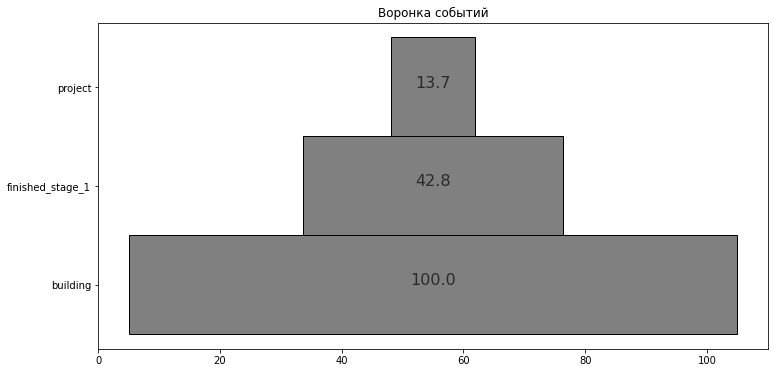

In [14]:
x_max = 110
x_min = 0
fig, ax = plt.subplots(1, figsize=(12,6))
for idx, val in enumerate(funnel['conv']):
    left = (x_max - val)/2
    plt.barh(funnel['event'][idx], funnel['conv'][idx], left = left, color='grey', height=1, edgecolor='black')
    # value
    plt.text(55, funnel['event'][idx], funnel['conv'][idx], ha='center',
             fontsize=16, color='#2A2A2A')
plt.xlim(x_min, x_max)
plt.title('Воронка событий');

До этапа завершения проекта добрались только 13%

##### Вывод

Самое частое событие - постройка. В то время как, самая частая постройка - космопорт. На воронке событий видно, что проект завершили только 13% игроков.

#### 4. Исследовательский анализ данных

Создадим пользовательские профили

In [15]:
def get_profiles(sessions, source, ad_costs):  # функция для создания пользовательских профилей

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'event_datetime'])
        .groupby('user_id')
        .agg(
            {
                'event_datetime': 'first'
            }
        )
        .rename(columns={'event_datetime': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    profiles['date'] = profiles['first_ts'].dt.date

    # присоединяем к данным о прохождении игры данные об источнике
    profiles = profiles.merge(source, on=['user_id'], how='left')

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['date', 'source'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['date', 'source'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['cost'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['date', 'source', 'acquisition_cost']],
        on=['date', 'source'],
        how='left',
    )

    return profiles

In [16]:
profiles = get_profiles(game_actions, user_source, ad_costs)  #профили пользователей
display(profiles.head()) 

,user_id,first_ts,date,source,acquisition_cost
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-06,facebook_ads,0.754174
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,2020-05-06,yandex_direct,0.464202
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,2020-05-05,youtube_channel_reklama,0.390754
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-05,instagram_new_adverts,0.631822
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,2020-05-05,facebook_ads,0.790130


Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего пользователей

,user_id
source,
facebook_ads,2726
instagram_new_adverts,3347
yandex_direct,4817
youtube_channel_reklama,2686


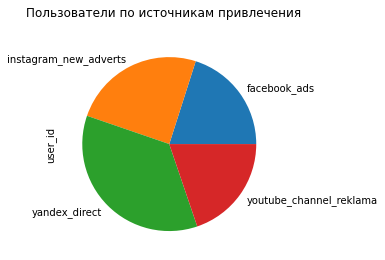

In [17]:
players_by_source = profiles.groupby('source').agg({'user_id': 'nunique'})
display(players_by_source)
players_by_source.plot(kind='pie', subplots=True, legend=False, title='Пользователи по источникам привлечения');

Распределение пользователей по источникам привлечения примерно равномерное. Но yandex_direct все же чуть вырывается вперед. На втором месте - instagram_new_adverts

Посчитаем время прохождения уровня игроками, завершившими проект. Добавим в датафрейм с профилями некоторые столбцы из game_actions для удобства. Добавим колонку с временем, которое прошло с начала игры до совершения действия.

In [18]:
profiles_with_actions = profiles.merge(
        game_actions[['event_datetime', 'event', 'user_id', 'project_type']],
        on=['user_id'],
        how='left',
    )

In [19]:
profiles_with_actions['time_on_event'] = (profiles_with_actions['event_datetime'] - profiles_with_actions['first_ts']).dt.days
profiles_with_actions.head()

,user_id,first_ts,date,source,acquisition_cost,event_datetime,event,project_type,time_on_event
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-06,facebook_ads,0.754174,2020-05-06 01:07:37,building,NaN,0
1,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-06,facebook_ads,0.754174,2020-05-06 11:31:56,building,NaN,0
2,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-06,facebook_ads,0.754174,2020-05-06 15:11:50,building,NaN,0
3,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-06,facebook_ads,0.754174,2020-05-09 05:59:57,building,NaN,3
4,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,2020-05-06,facebook_ads,0.754174,2020-05-09 07:35:40,building,NaN,3


Отсортируем пользователей по признаку завершения проекта. Добавим колонку со временем прохождения игры

In [20]:
winners = profiles_with_actions.query('event == ["project", "finished_stage_1"]')
finished_level = profiles_with_actions[profiles_with_actions["user_id"].isin(winners['user_id'])] # создаем датафрейм с пользователями, прошедшими уровень
finished_level = finished_level.merge(winners[['time_on_event', 'user_id']], on=['user_id'], how='left')
finished_level = finished_level.rename(columns={'time_on_event_x': 'days_on_event', 'time_on_event_y': 'days_on_level'})
finished_level.head()

,user_id,first_ts,date,source,acquisition_cost,event_datetime,event,project_type,days_on_event,days_on_level
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-05,instagram_new_adverts,0.631822,2020-05-05 21:02:05,building,NaN,0,6
1,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-05,instagram_new_adverts,0.631822,2020-05-06 10:52:38,building,NaN,0,6
2,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-05,instagram_new_adverts,0.631822,2020-05-06 16:54:55,building,NaN,0,6
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-05,instagram_new_adverts,0.631822,2020-05-07 14:58:27,building,NaN,1,6
4,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-05,instagram_new_adverts,0.631822,2020-05-07 23:26:08,building,NaN,2,6


In [21]:
print('В среднем ушло на прохождение уровня игроками:', finished_level['days_on_level'].mean().round(), 'дней')

В среднем ушло на прохождение уровня игроками: 12.0 дней


##### Вывод

Больше всего пользователей пришло через yandex_direct, хотя отрыв незначитальный. На втором месте - instagram_new_adverts. Меньше всего пришло через youtube_channel_reklama. По времени - в среднем на прохождение уровня у пользователей ушло 12 дней.

#### 5. Маркетинг

In [22]:
print('Всего денег потрачено:', sum(ad_costs['cost']))

Всего денег потрачено: 7603.57


Посмотрим на распределение затрат по источникам привлечения

,cost
source,
facebook_ads,2140.90
instagram_new_adverts,2161.45
yandex_direct,2233.11
youtube_channel_reklama,1068.11


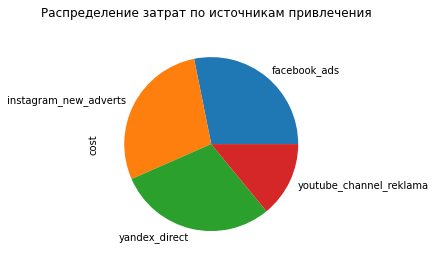

In [23]:
costs_by_source = ad_costs.groupby('source').agg({'cost': 'sum'})
display(costs_by_source)
costs_by_source.plot(kind='pie', subplots=True, legend=False, title='Распределение затрат по источникам привлечения');

Затраты на рекламу распределяются примерно также, как количество переходов - более-менее равномерно. Опять же выделяется yandex_direct - на него потратили чуть больше денег. Самый дешевый - youtube_channel_reklama

Выясним, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.

In [24]:
print('Средняя стоимость привлечения одного пользователя в общем:', profiles['acquisition_cost'].mean())
profiles.pivot_table(index='source', 
                     values='acquisition_cost', 
                     aggfunc='mean').reset_index().sort_values(by='acquisition_cost', 
                                                               ascending=False).round(2) 
# сколько в среднем стоит привлечение одного покупателя из разных источников

Средняя стоимость привлечения одного пользователя в общем: 0.5600743959929286


,source,acquisition_cost
0,facebook_ads,0.79
1,instagram_new_adverts,0.65
2,yandex_direct,0.46
3,youtube_channel_reklama,0.40


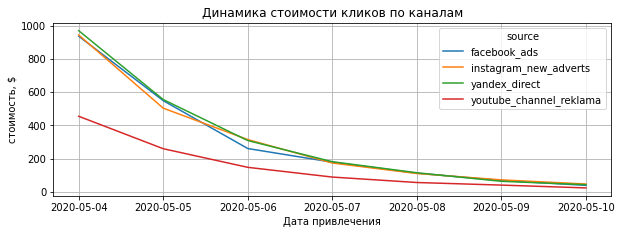

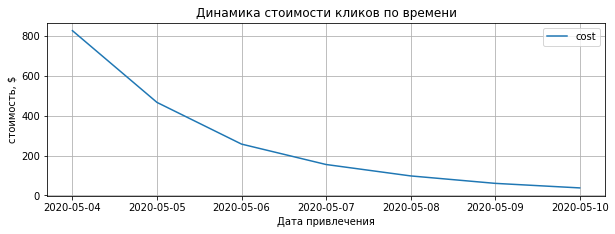

In [25]:
# первый график - динамика стоимости кликов по каналам продвижения
ax1 = plt.subplot(2, 1, 1)
ad_costs.pivot_table(
    index='date', columns='source', values='cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 7), ax=ax1)
plt.ylabel('стоимость, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика стоимости кликов по каналам')
plt.show()

# второй график - динамика стоимости кликов по времени
ax2 = plt.subplot(2, 1, 2)
ad_costs.pivot_table(
    index='date', values='cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 7), ax=ax2)
plt.ylabel('стоимость, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика стоимости кликов по времени')
plt.show()

##### Вывод

Самый дешевый источник - youtube_channel_reklama. Но через него пришло и меньше всего пользователей. Графики стоимости у остальных источников почти одинаковые. В целом динамика отрицательная - со временем на привлечение тратится все меньше средств. Это может быть связано с отсутствием рекламы в целом.

#### 6. Проверка статистических гипотез
    

H0: время завершения уровня различается в зависимости способа прохождения;
H1: время завершения уровня не зависит от способа прохождения.
Проверку будем осуществлять методом сравнения средних двух генеральных совокупностей. Критический уровнь значимости обозначим на уровне 0.05.

In [26]:
alpha = .05

results = stats.ttest_ind(
    finished_level.loc[finished_level['event'] == 'project', 'days_on_level'], 
    finished_level.loc[finished_level['event'] == 'finished_stage_1', 'days_on_level'])

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.9775007984859473e-25
Отвергаем нулевую гипотезу


Проверка первой гипотезы показала, что время завершения уровня не зависит от способа прохождения игры

Авторская гипотеза: 
    Н0 - достижение этапа исследования спутниковой станции не зависит от источника привлечения,
    Н1 - между достижением этапа исследования спутниковой станции и источником привлечения прослеживается зависимость
Посчитаем статистическую значимость методом проверки гипотезы о равенстве долей (z-test). Критический уровнь значимости обозначим на уровне 0.002 с учетом поправки Бонферрони на последующие 24 теста.

In [27]:
def check_hypothesis(successes1, successes2, trials1, trials2):   # функция для проверки статистической значимости различий в прохождении игры
    p1 = successes1/trials1
    p2 = successes2/trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

trials = profiles_with_actions.groupby('source').agg({'user_id': 'nunique'})
display(trials)
funnel_by_groups = profiles_with_actions.pivot_table(index='project_type', columns = 'source', values = 'user_id', aggfunc='nunique')
display(funnel_by_groups)

,user_id
source,
facebook_ads,2726
instagram_new_adverts,3347
yandex_direct,4817
youtube_channel_reklama,2686


source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
project_type,,,,
satellite_orbital_assembly,391,476,620,379


In [28]:
funnel_by_groups.loc['satellite_orbital_assembly', 'p_value_fb/insta'] = check_hypothesis(funnel_by_groups.loc['satellite_orbital_assembly', 'facebook_ads'], funnel_by_groups.loc['satellite_orbital_assembly', 'instagram_new_adverts'],
                                       trials.loc['facebook_ads'].values[0], trials.loc['instagram_new_adverts'].values[0])
funnel_by_groups.loc['satellite_orbital_assembly', 'p_value_fb/ya'] =  check_hypothesis(funnel_by_groups.loc['satellite_orbital_assembly', 'facebook_ads'], funnel_by_groups.loc['satellite_orbital_assembly', 'yandex_direct'],
                                       trials.loc['facebook_ads'].values[0], trials.loc['yandex_direct'].values[0])
funnel_by_groups.loc['satellite_orbital_assembly', 'p_value_fb/yout'] =  check_hypothesis(funnel_by_groups.loc['satellite_orbital_assembly', 'facebook_ads'], funnel_by_groups.loc['satellite_orbital_assembly', 'youtube_channel_reklama'],
                                       trials.loc['facebook_ads'].values[0], trials.loc['youtube_channel_reklama'].values[0])
funnel_by_groups.loc['satellite_orbital_assembly', 'p_value_insta/ya'] =  check_hypothesis(funnel_by_groups.loc['satellite_orbital_assembly', 'instagram_new_adverts'], funnel_by_groups.loc['satellite_orbital_assembly', 'yandex_direct'],
                                       trials.loc['instagram_new_adverts'].values[0], trials.loc['yandex_direct'].values[0]) 
funnel_by_groups.loc['satellite_orbital_assembly', 'p_value_insta/yout'] =  check_hypothesis(funnel_by_groups.loc['satellite_orbital_assembly', 'instagram_new_adverts'], funnel_by_groups.loc['satellite_orbital_assembly', 'youtube_channel_reklama'],
                                       trials.loc['instagram_new_adverts'].values[0], trials.loc['youtube_channel_reklama'].values[0])    
funnel_by_groups.loc['satellite_orbital_assembly', 'p_value_ya/yout'] =  check_hypothesis(funnel_by_groups.loc['satellite_orbital_assembly', 'yandex_direct'], funnel_by_groups.loc['satellite_orbital_assembly', 'youtube_channel_reklama'],
                                       trials.loc['yandex_direct'].values[0], trials.loc['youtube_channel_reklama'].values[0])
funnel_by_groups   

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama,p_value_fb/insta,p_value_fb/ya,p_value_fb/yout,p_value_insta/ya,p_value_insta/yout,p_value_ya/yout
project_type,,,,,,,,,,
satellite_orbital_assembly,391,476,620,379,0.892765,0.071376,0.80607,0.078318,0.901789,0.129873


In [29]:
funnel_comb = profiles_with_actions.pivot_table(index='project_type', columns = 'source', values = 'user_id', aggfunc='nunique')
funnel_comb['fb/insta/yout'] = funnel_comb['facebook_ads'] + funnel_comb['instagram_new_adverts'] + funnel_comb['youtube_channel_reklama']

funnel_comb.loc['satellite_orbital_assembly', 'p_value'] = check_hypothesis(funnel_comb.loc['satellite_orbital_assembly', 'yandex_direct'], funnel_comb.loc['satellite_orbital_assembly', 'fb/insta/yout'],
                                       trials.loc['yandex_direct'].values[0], (trials.loc['facebook_ads'].values[0] + trials.loc['instagram_new_adverts'].values[0] + trials.loc['youtube_channel_reklama'].values[0]))

funnel_comb

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama,fb/insta/yout,p_value
project_type,,,,,,
satellite_orbital_assembly,391,476,620,379,1246,0.02833


Нулевая гипотеза не опровергнута - достижение этапа исследования спутниковой станции не зависит от источника привлечения.
По выведенной выше таблице видно, что больше всего "побед" наблюдается у тех, кто пришел через yandex_direct.

#### 8. Общий вывод. Подготовка дашборда и презентации.

В ходе исследования мы изучили данные и привели к нужному виду, проверили на аномалии и очистили данные, построили и проанализировали воронку событий. Далее мы провели исследовательский анализ данных и анализ маркетинговых показатателей. В финале провели проверку статистических гипотез.

В процессе мы выяснили, что:

    - самое частое событие в игре - постройка. В то время как, самая частая постройка - космопорт;
    - На воронке событий видно, что проект завершили только 13% игроков;
    - Самый дешевый источник - youtube_channel_reklama. Но через него пришло и меньше всего пользователей. Графики стоимости у остальных источников почти одинаковые. В целом динамика отрицательная - со временем на привлечение тратится все меньше средств. Это может быть связано с отсутствием рекламы в целом.
    - Проверка гипотез показала, что время завершения уровня не зависит от способа прохождения игры и что достижение этапа исследования спутниковой станции не зависит от источника привлечения (больше всего "побед" наблюдается у тех, кто пришел через yandex_direct).
    
Подытожив, можно сказать, что самый удачный источник привлечения - yandex_direct. Не смотря на то, что он чуть дороже все остальных, он самый результативный и приводит самых активных игроков (нацеленных на победу).